### Dispenser Usage v2 - Mask

#### Background
- Detecting Hand Hygiene Dispenser Use
- See: https://docs.google.com/document/d/1iPzdrs4tEbltL9iHykD_KKQxFjcWRBDu5fH6YkuxFFM/edit

##### Notebook
- Subtracts first frame from each subsequent frame to produce a "mask", taking into account noise.
- Trains a model to predict "is_clean" from the "mask".
   - ResNet-50 base model
   - ConvLSTM2D layer
   - AvgPool
   - Dense (128)
   - Dropout (0.2)
   - Dense (sigmoid)

##### Results
- Train Accuracy: 95.8%
- Val Accuracy: 87.5%
- 29 epochs


In [1]:
from google.colab imprt drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://aicare.stanford.edu/sep2020.tar.gz

--2020-09-19 17:09:37--  https://aicare.stanford.edu/sep2020.tar.gz
Resolving aicare.stanford.edu (aicare.stanford.edu)... 171.64.68.86
Connecting to aicare.stanford.edu (aicare.stanford.edu)|171.64.68.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224617454 (214M) [application/x-gzip]
Saving to: ‘sep2020.tar.gz’

sep2020.tar.gz      100%[===================>] 214.21M  5.83MB/s    in 44s     

2020-09-19 17:10:22 (4.81 MB/s) - ‘sep2020.tar.gz’ saved [224617454/224617454]



In [3]:
!tar -xzf sep2020.tar.gz

In [4]:
!ls hh_data

labels.json  mp4  npy


In [5]:
!nvidia-smi

Sat Sep 19 17:10:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load the labels


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
from os import listdir
from os.path import isfile, join, exists
from sklearn.model_selection import train_test_split

In [7]:
import json

video_to_room = {}
video_to_class = {}
with open("hh_data/labels.json", "r") as f:
    labels_obj = json.load(f)
    for k, v in labels_obj.items():
        video_to_room[k] = v["room"]
        video_to_class[k] = v["is_clean"]
classes = list(set(video_to_class.values()))

video_ids = []
frame_numbers = []
# Because some videos are being held back, we are just going to filter for videos we know about
for k in video_to_class.keys():
    if exists("hh_data/npy/" + k + ".npy"):
        video_ids.append(k)
        video_obj = np.load("hh_data/npy/" + k + ".npy")
        frame_numbers.append(video_obj.shape[0])
print(f"Max frames: {np.max(frame_numbers)}")
print(f"Min frames: {np.min(frame_numbers)}")
print(f"Avg frames: {np.mean(frame_numbers)}")
print(f"Avg frames: {np.median(frame_numbers)}")


Max frames: 200
Min frames: 5
Avg frames: 32.562913907284766
Avg frames: 25.0


In [8]:
NUM_FRAMES = 24
BATCH_SIZE = 16
IMG_HEIGHT = 240
IMG_WIDTH = 320

def normalize(a):
    return (255*(a/np.max(a))).astype(int)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_dir, video_ids, video_to_class, classes, num_frames=NUM_FRAMES, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.video_dir = video_dir
        self.video_ids = video_ids
        self.video_to_class = video_to_class
        self.shuffle = shuffle
        self.classes = classes
        self.on_epoch_end()
        print(f"Found {len(self.video_ids)} videos belonging to {len(self.classes)} classes.")

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.video_ids) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_ids = self.video_ids[index*self.batch_size:(index+1)*self.batch_size]

        # Depth videos are "greyscale" but for transfer learning we need three channels
        X = np.zeros((len(video_ids), self.num_frames, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        y = []
        i = 0
        for video_id in video_ids:
            video = np.load(join(self.video_dir, video_id + ".npy"))
            curr_frames = video.shape[0]

            # Convert npy to float32 to avoid processing problems
            # num_frames, 240, 320
            base_video = np.zeros((self.num_frames, IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

            # First frame is taken as the stationary background reference point 
            first_frame = video[0, :, :]

            # Number of frames are uneven, so we will evenly sample across all video frames
            # if the number of frames are more than the frames we want to use
            if self.num_frames < curr_frames:
                indices = np.round(np.linspace(0, curr_frames - 1, self.num_frames)).astype(int)
                base_video[:, :, :] = video[indices, :, :]
            else:
                base_video[:min(curr_frames, self.num_frames), :, :] = video[:min(curr_frames, self.num_frames), :, :].astype(np.float32)

            base_video = first_frame - base_video
            base_video[base_video<10] = 0

            # Repeat the depth image three times to simulate RGB
            video = base_video[:, :, :, np.newaxis]
            video = normalize(video)
            video = np.repeat(video, 3, -1)

            X[i, :, :, :] = video

            # Classes are 0 or 1
            y.append(self.video_to_class[video_id])

            i += 1

        y = np.array(y)

        return X[:, :, :, :, :].astype(np.int), tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        """
        Shuffles the data upon completion of a full epoch 
        """
        if self.shuffle == True:
            np.random.shuffle(self.video_ids)




In [9]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

BATCH_SIZE = 8

In [10]:
video_ids_train, video_ids_val = train_test_split(video_ids, test_size=0.2)

train_generator = DataGenerator("hh_data/npy", video_ids_train, video_to_class, classes, batch_size=BATCH_SIZE)

validation_generator = DataGenerator("hh_data/npy", video_ids_val, video_to_class, classes, batch_size=BATCH_SIZE)



Found 241 videos belonging to 2 classes.
Found 61 videos belonging to 2 classes.


In [11]:
print(video_ids_train)

['326', '062', '018', '289', '047', '306', '342', '317', '351', '284', '320', '275', '451', '036', '140', '302', '070', '348', '126', '089', '448', '377', '321', '061', '485', '024', '028', '270', '155', '021', '158', '051', '370', '271', '344', '292', '472', '364', '127', '066', '299', '349', '057', '265', '307', '056', '461', '071', '368', '025', '288', '469', '347', '285', '280', '260', '279', '141', '439', '264', '357', '438', '468', '022', '482', '319', '338', '133', '103', '277', '337', '369', '086', '003', '374', '058', '318', '372', '110', '142', '441', '460', '345', '093', '097', '261', '334', '308', '458', '273', '083', '073', '484', '274', '443', '090', '375', '084', '032', '336', '447', '470', '366', '358', '303', '440', '312', '465', '014', '343', '300', '298', '108', '129', '111', '444', '313', '329', '154', '480', '454', '483', '132', '109', '283', '143', '341', '054', '481', '091', '038', '328', '095', '002', '367', '291', '363', '373', '123', '455', '085', '106', '005'

In [12]:
print(video_ids_val)

['131', '464', '281', '034', '315', '059', '107', '296', '068', '139', '267', '113', '150', '135', '114', '475', '268', '112', '152', '006', '294', '353', '290', '081', '077', '011', '087', '115', '449', '276', '478', '076', '053', '096', '340', '376', '064', '335', '031', '069', '269', '063', '295', '136', '371', '365', '331', '479', '008', '473', '144', '314', '263', '457', '333', '310', '147', '033', '304', '325', '074']


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


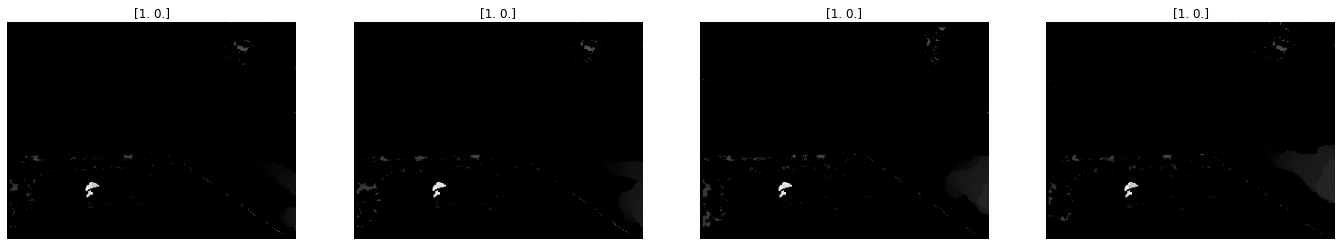

In [13]:
def show_batch(image_batch, label_batch, index, offset):
    plt.figure(figsize=(30, 30))
    for i in range(4):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(image_batch[index, i + offset]) # second frame from each video
        plt.title(label_batch[index])
        plt.axis('off')
image_batch, label_batch = train_generator.__getitem__(0)
show_batch(image_batch, label_batch, index=5, offset=7)

In [19]:
from pathlib import Path

BASE_NAME = "resnet50"
MODEL_NAME = "dispenser-mask-v2"
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/svl-pac/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/svl-pac/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    base_model = get_base_model(BASE_NAME)
    base_model.trainable = False

    x = tf.keras.layers.TimeDistributed(base_model)(inputs)
    x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(128, activation='softmax')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 24, 240, 320, 3)] 0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 8, 10, 2048)   23587712  
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 24, 8, 10, 64)     4866304   
_________________________________________________________________
global_average_pooling3d_3 ( (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

In [16]:
initial_epochs = 30

# Try evaluating the model for a few rounds
loss, accuracy = model.evaluate(validation_generator, steps = 3)

3/3 [==============================] - 1s 432ms/step - loss: 0.7011 - accuracy: 0.2500


In [17]:
validation_generator.batch_size

8

In [20]:
import pickle
history = model.fit(
          train_generator,
          epochs=initial_epochs,
          callbacks=[cp_callback],
          validation_data=validation_generator
)


Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5542
Epoch 00001: val_loss improved from inf to 0.66740, saving model to drive/My Drive/svl-pac/checkpoints/dispenser-mask-v2/cp-0001.ckpt
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/svl-pac/checkpoints/dispenser-mask-v2/cp-0001.ckpt/assets
30/30 [==============================] - 55s 2s/step - loss: 0.6922 - accuracy: 0.5542 - val_loss: 0.6674 - val_accuracy: 0.6964
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.5542
Epoch 00002: val_loss did not improve from 0.66740
30/30 [==============================] - 25s 826ms/step - loss: 0.6885 - accuracy: 0.5542 - val_loss: 0.6725 - val_accuracy: 0.6607
Epoch 3/30
30/30 [======

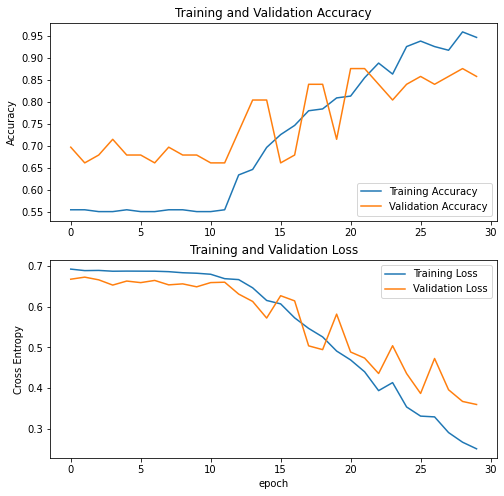

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

model.save(f"drive/My Drive/svl-pac/checkpoints/{MODEL_NAME}/m1.h5")
